# Time series weather experiment using LSTM network and Keras
!Still under progress, some tuning of parameters would be useful!
Sources:
- https://www.tensorflow.org/tutorials/structured_data/time_series
- https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb
- https://blogs.rstudio.com/tensorflow/posts/2017-12-20-time-series-forecasting-with-recurrent-neural-networks/
- https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
- https://blogs.rstudio.com/tensorflow/posts/2017-12-20-time-series-forecasting-with-recurrent-neural-networks/
- https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb
- https://stackoverflow.com/questions/43117654/many-to-many-sequence-prediction-with-different-sequence-length
- https://datascience.stackexchange.com/questions/31923/training-an-lstm-to-track-sine-waves
- https://www.bgc-jena.mpg.de/wetter/ (datasets)
- https://tyueh.me/jenas-temperature-forecasting/
- https://www.bgc-jena.mpg.de/wetter/Wetterstation.pdf (description of dataset, in German)

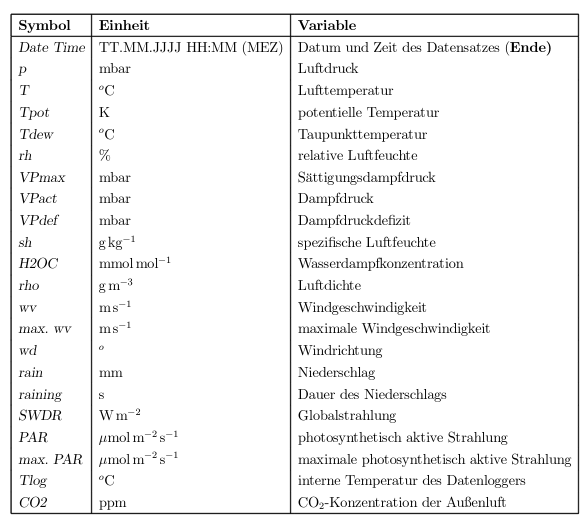

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file

In [3]:
archive_file = 'jena_climate_2009_2016.csv.zip'
target_file = 'jena_climate_2009_2016.csv'

if not os.path.exists(target_file):
    zip_path = get_file(
        origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
        fname=archive_file,
        cache_dir='results',
        extract=True)

    csv_path, _ = os.path.splitext(zip_path)
    os.rename(csv_path, target_file)

In [4]:
# observations are recorded every 10 minutes
dataset = pd.read_csv(target_file)
dataset.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
Date Time          420551 non-null object
p (mbar)           420551 non-null float64
T (degC)           420551 non-null float64
Tpot (K)           420551 non-null float64
Tdew (degC)        420551 non-null float64
rh (%)             420551 non-null float64
VPmax (mbar)       420551 non-null float64
VPact (mbar)       420551 non-null float64
VPdef (mbar)       420551 non-null float64
sh (g/kg)          420551 non-null float64
H2OC (mmol/mol)    420551 non-null float64
rho (g/m**3)       420551 non-null float64
wv (m/s)           420551 non-null float64
max. wv (m/s)      420551 non-null float64
wd (deg)           420551 non-null float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [7]:
dataset.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [8]:
dataset.shape

(420551, 15)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002489B82B128>,
      dtype=object)

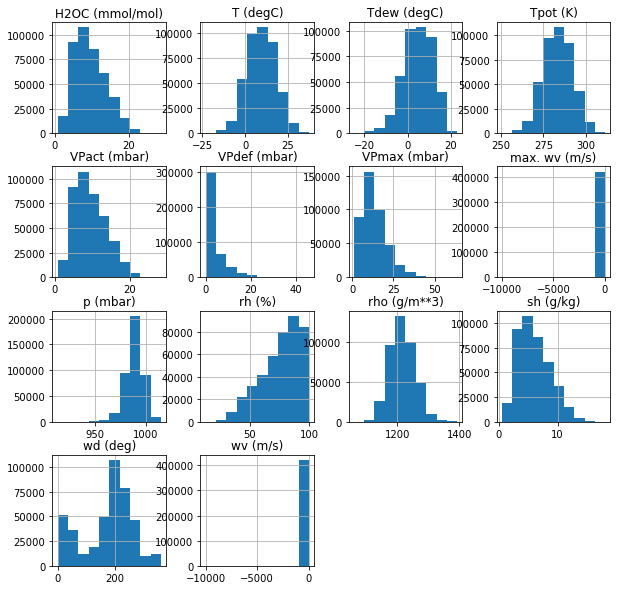

In [9]:
dataset.hist(bins=10, figsize=(10, 10))

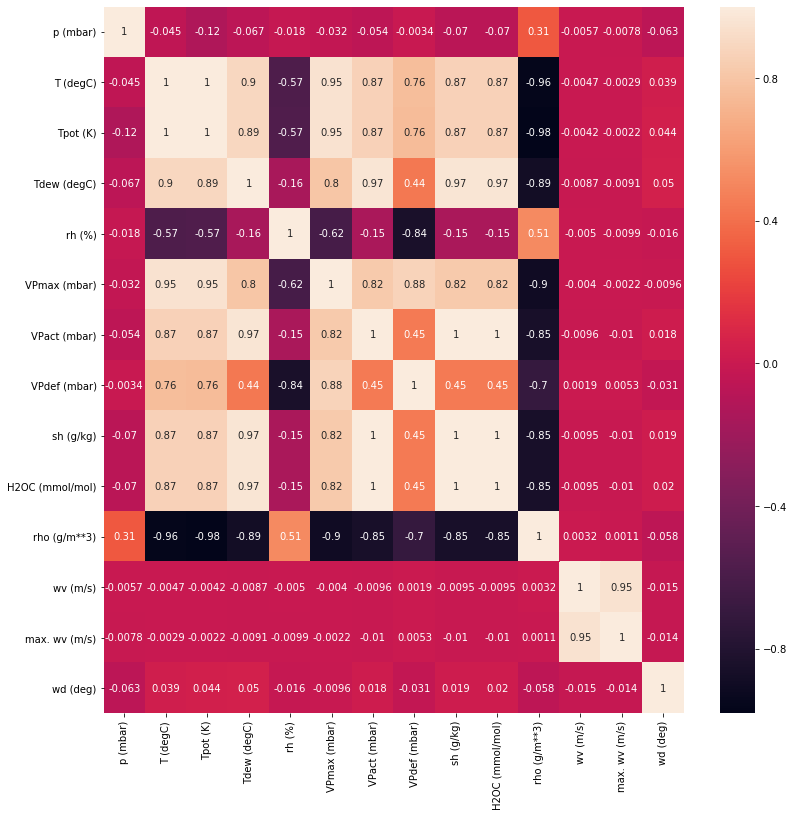

In [10]:
# show correlations
import seaborn as sns

corr = dataset.corr()

fig, ax = plt.subplots(figsize=(13,13))
sns.heatmap(corr, annot = True, ax=ax)

In [127]:
# UNIVARIATE DATE ANALYSIS - single input variable
uni_features = ['T (degC)']

uni_data = dataset[uni_features]
uni_data.index = dataset['Date Time']
uni_data.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002489D9F7748>],
      dtype=object)

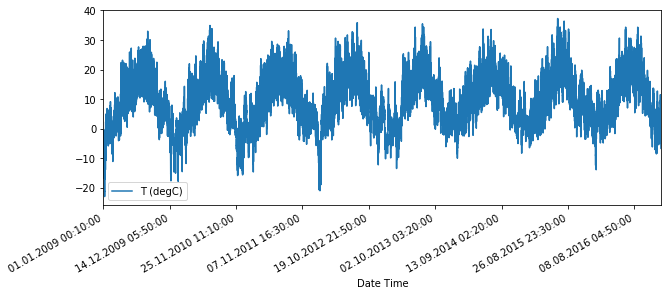

In [12]:
uni_data.plot(subplots=True, figsize=(10,4))

In [13]:
# support functions

def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    
    return plt


def extract_features_and_labels(dataset_features, dataset_target, start_index, end_index, history_size, target_size, step):
    """
    Prepare input and labels extracted from provided dataset
    Parameters:
      dataset_features - source of input features
      dataset_target - source of labels
      start_index - row of data start
      end_index - row of data end
      history_size - how many items to consider from the history
      target_size - future value index
      step - step between start and end index to ignore some data
    """
    
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset_features) - target_size

    for i in range(start_index, end_index, step):
        indices = range(i-history_size, i, step)
        data.append(dataset_features[indices])
        labels.append(dataset_target[i+target_size])

    return np.array(data), np.array(labels)

In [131]:
from sklearn.preprocessing import MinMaxScaler

# 300,000 rows of the data will is the training dataset, 
# the rest is the validation dataset (cca 2100 days of training data).
TRAIN_SPLIT = 300000

uni_data_values = uni_data.values

# scale feature and/or target values
uni_data_mean = uni_data_values[:TRAIN_SPLIT].mean(axis=0)
uni_data_std = uni_data_values[:TRAIN_SPLIT].std(axis=0)
uni_data_values = (uni_data_values - uni_data_mean) / uni_data_std

# For the prediction 5 days are considered (720 observations sampled every hour)
# (no big change every 10 minutes here).
# 120 observations represent history of the last five days.
# The temperature after 12 hours is predicted, so after 72 (12*6) observations.

# consider 5 days
past_history = 720
# 12 hours to the future
future_target = 72
# every hour
step = 6

# def extract_features_and_labels(dataset_features, dataset_target, start_index, end_index, history_size, target_size, step)

x_train_uni, y_train_uni = extract_features_and_labels(
                                    uni_data_values,
                                    uni_data_values,
                                    0,
                                    TRAIN_SPLIT,
                                    past_history,
                                    future_target,
                                    step
)

x_val_uni, y_val_uni = extract_features_and_labels(
                                    uni_data_values,
                                    uni_data_values,
                                    TRAIN_SPLIT,
                                    None,
                                    past_history,
                                    future_target,
                                    step
)

print('x_train_uni:', x_train_uni.shape)
print('y_train_uni:', y_train_uni.shape)
print('x_val_uni:', x_val_uni.shape)
print('y_val_uni:', y_val_uni.shape)

x_train_uni: (49880, 120, 1)
y_train_uni: (49880, 1)
x_val_uni: (19960, 120, 1)
y_val_uni: (19960, 1)


<module 'matplotlib.pyplot' from 'c:\\apps\\python36\\lib\\site-packages\\matplotlib\\pyplot.py'>

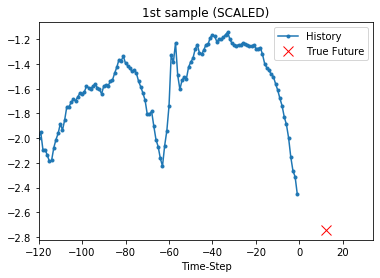

In [143]:
show_plot([x_train_uni[0], y_train_uni[0]], 12, '1st sample (SCALED)')

In [144]:
# Create NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, GRU
from tensorflow.keras import optimizers

input_shape = (120,1)

# define a sequential model
model = Sequential()

# To stack recurrent layers on top of each other in Keras, all intermediate layers should return 
# their full sequence of outputs (a 3D tensor) rather than their output at the last timestep.
# This is done by specifying return_sequences=True

#model.add(GRU(32, input_shape=input_shape, return_sequences = True))
#model.add(GRU(32, return_sequences = False))

# defaults: activation='tanh', recurrent_activation='sigmoid'
# see: https://tyueh.me/jenas-temperature-forecasting/
# -> I cannot reproduce the learning, the error stays at 0.04

model.add(LSTM(64, input_shape=input_shape, return_sequences = True))
model.add(LSTM(32, return_sequences = False))
model.add(Dense(1))
model.add(Activation('linear'))

opt_Adam = optimizers.Adam(lr=0.001, beta_1=0.8, beta_2=0.8, epsilon=1e-07, decay=0.0, amsgrad=False)
#opt_RMS = optimizers.RMSprop(learning_rate=0.001, rho=0.8)

# build model
model.compile(optimizer=opt_Adam,
             loss='mean_absolute_error',
             metrics=['mae'])


In [145]:
epochs = 10

history = model.fit(
    x_train_uni,
    y_train_uni,
    batch_size=200,
    epochs=epochs,
    validation_data=(x_val_uni, y_val_uni),
    shuffle=False
)

Train on 49880 samples, validate on 19960 samples
Epoch 1/10
49880/49880 [==============================] - 157s 3ms/sample - loss: 0.3466 - mae: 0.3466 - val_loss: 0.3267 - val_mae: 0.3267
Epoch 2/10
49880/49880 [==============================] - 154s 3ms/sample - loss: 0.3169 - mae: 0.3169 - val_loss: 0.3781 - val_mae: 0.3781
Epoch 3/10
49880/49880 [==============================] - 170s 3ms/sample - loss: 0.3129 - mae: 0.3129 - val_loss: 0.3706 - val_mae: 0.3706
Epoch 4/10
49880/49880 [==============================] - 154s 3ms/sample - loss: 0.3099 - mae: 0.3099 - val_loss: 0.3794 - val_mae: 0.3794
Epoch 5/10
49880/49880 [==============================] - 155s 3ms/sample - loss: 0.3077 - mae: 0.3077 - val_loss: 0.3710 - val_mae: 0.3710
Epoch 6/10
49880/49880 [==============================] - 170s 3ms/sample - loss: 0.3051 - mae: 0.3051 - val_loss: 0.3641 - val_mae: 0.3641
Epoch 7/10
49880/49880 [==============================] - 158s 3ms/sample - loss: 0.3025 - mae: 0.3025 - val_l

In [146]:
def plot_model_history(model_history):
    history_dict = model_history.history

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values, 'b', label='Training loss', color='blue')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss', color='yellow')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

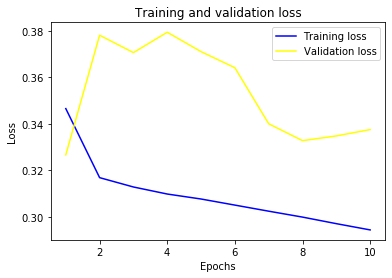

In [147]:
plot_model_history(history)

In [148]:
y_val_uni_predicted = model.predict(x_val_uni)
y_val_uni_predicted = uni_scaler.inverse_transform(y_val_uni_predicted)
y_val_uni_real = uni_scaler.inverse_transform(y_val_uni)

In [149]:
y_val_uni_predicted.shape

(19960, 1)

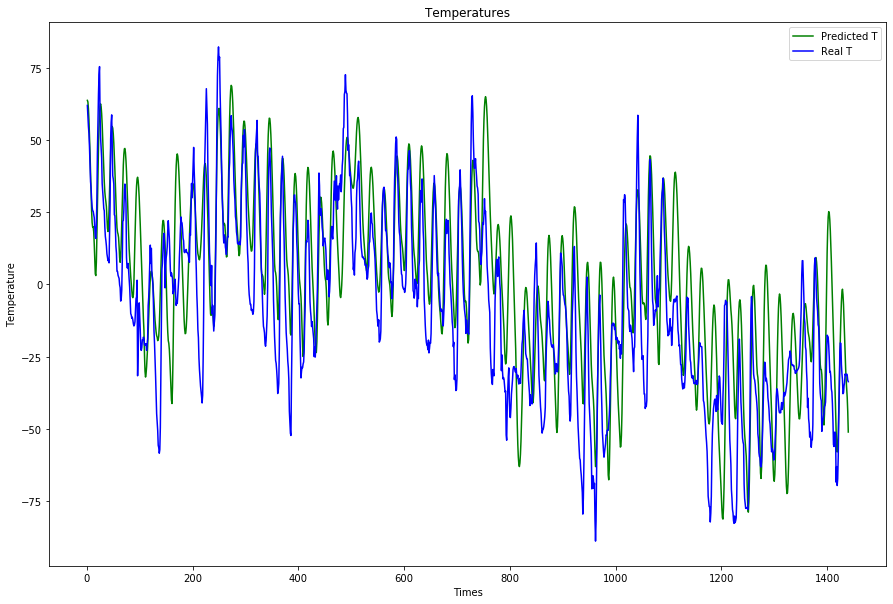

In [150]:
max_hours = 60 * 24
plt.figure(figsize=(15,10))
times = range(1, len(y_val_uni_predicted) + 1)
plt.plot(times[:max_hours], y_val_uni_predicted[:max_hours], 'b', label='Predicted T', color='green')
plt.plot(times[:max_hours], y_val_uni_real[:max_hours], 'b', label='Real T', color='blue')
plt.title('Temperatures')
plt.xlabel('Times')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [26]:
# MULTIVARIATE DATE ANALYSIS - use more input variables (TEMPERATURE, PRESSURE, HUMIDITY)
multi_features = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']

multi_data = dataset[multi_features]
multi_data.index = dataset['Date Time']
multi_data.head()

,T (degC),p (mbar),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,-8.02,996.52,1307.75
01.01.2009 00:20:00,-8.41,996.57,1309.80
01.01.2009 00:30:00,-8.51,996.53,1310.24
01.01.2009 00:40:00,-8.31,996.51,1309.19
01.01.2009 00:50:00,-8.27,996.51,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000248A8717898>,
      dtype=object)

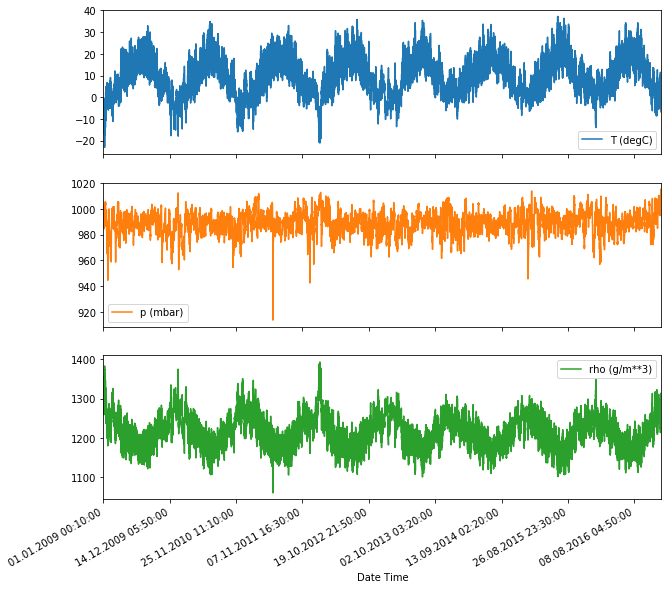

In [27]:
multi_data.plot(subplots=True, figsize=(10,10))

In [104]:
multi_data_values = multi_data.values

# def extract_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):

# scale feature and/or target values
multi_data_mean = multi_data_values[:TRAIN_SPLIT].mean(axis=0)
#print ('multi_data_mean:', multi_data_mean)
multi_data_std = multi_data_values[:TRAIN_SPLIT].std(axis=0)
#print ('multi_data_std:', multi_data_std)
multi_data_values = (multi_data_values - multi_data_mean) / multi_data_std
#print ('multi_data_values:', multi_data_values)

x_train_multi, y_train_multi = extract_features_and_labels(
                                        multi_data_values,
                                        multi_data_values[:,0],
                                        0,
                                        TRAIN_SPLIT,
                                        past_history,
                                        future_target,
                                        step
)

x_val_multi, y_val_multi = extract_features_and_labels(
                                    multi_data_values,
                                    multi_data_values[:,0],
                                    TRAIN_SPLIT,
                                    None,
                                    past_history,
                                    future_target,
                                    step
)

print('x_train_multi:', x_train_multi.shape)
print('y_train_uni:', y_train_multi.shape)
print('x_val_multi:', x_val_multi.shape)
print('y_val_multi:', y_val_multi.shape)

x_train_multi: (49880, 120, 3)
y_train_uni: (49880,)
x_val_multi: (19960, 120, 3)
y_val_multi: (19960,)


In [114]:
# Create NN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras import optimizers

input_shape_multi = (120,3)

# define a sequential model
model_multi = Sequential()

model_multi.add(LSTM(64, return_sequences = True, input_shape=input_shape_multi))
#model_multi.add(LSTM(64, return_sequences = True))
model_multi.add(LSTM(64, return_sequences = False))
model_multi.add(Dense(1))
model_multi.add(Activation('linear'))

opt_multi = optimizers.Adam(lr=0.0005, beta_1=0.8, beta_2=0.8, epsilon=1e-07, decay=0.0, amsgrad=False)

# build model
model_multi.compile(optimizer=opt_multi,
             loss='mean_absolute_error',
             metrics=['mae'])

In [115]:
epochs = 20

history_multi = model_multi.fit(
    x_train_multi,
    y_train_multi,
    batch_size=64,
    epochs=epochs,
    validation_data=(x_val_multi, y_val_multi),
    shuffle=False
)

Train on 49880 samples, validate on 19960 samples
Epoch 1/20
49880/49880 [==============================] - 159s 3ms/sample - loss: 0.3198 - mae: 0.3198 - val_loss: 0.3092 - val_mae: 0.3092
Epoch 2/20
49880/49880 [==============================] - 165s 3ms/sample - loss: 0.2804 - mae: 0.2804 - val_loss: 0.3008 - val_mae: 0.3008
Epoch 3/20
49880/49880 [==============================] - 186s 4ms/sample - loss: 0.2730 - mae: 0.2730 - val_loss: 0.3001 - val_mae: 0.3001
Epoch 4/20
49880/49880 [==============================] - 185s 4ms/sample - loss: 0.2682 - mae: 0.2682 - val_loss: 0.3090 - val_mae: 0.3090
Epoch 5/20
49880/49880 [==============================] - 175s 4ms/sample - loss: 0.2656 - mae: 0.2656 - val_loss: 0.3115 - val_mae: 0.3115
Epoch 6/20
49880/49880 [==============================] - 181s 4ms/sample - loss: 0.2640 - mae: 0.2640 - val_loss: 0.3144 - val_mae: 0.3144
Epoch 7/20
49880/49880 [==============================] - 173s 3ms/sample - loss: 0.2631 - mae: 0.2631 - val_l

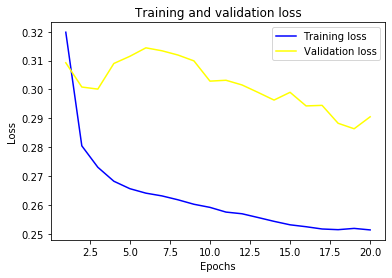

In [116]:
plot_model_history(history_multi)

In [117]:
y_val_multi_predicted = model_multi.predict(x_val_multi)

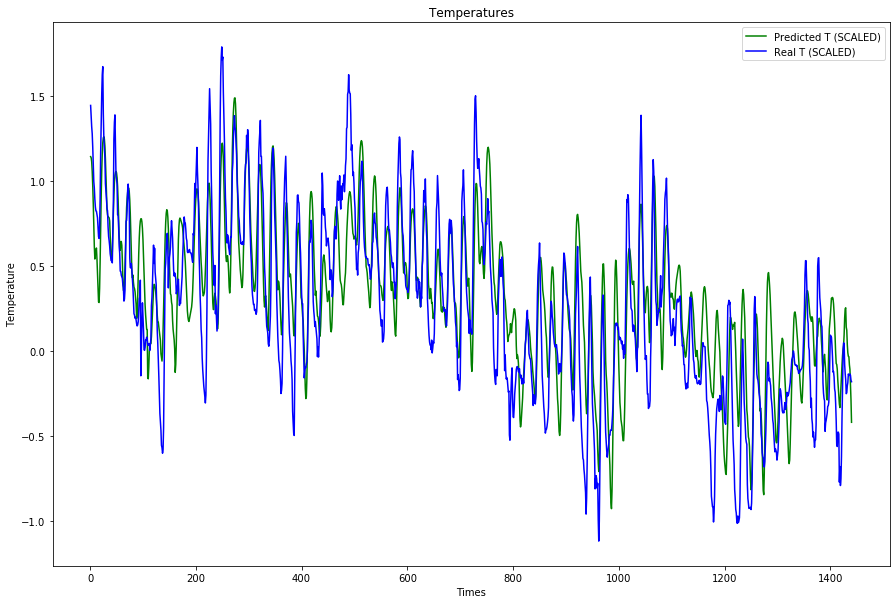

In [118]:
max_hours = 60 * 24
plt.figure(figsize=(15,10))
times = range(1, len(y_val_multi_predicted) + 1)
plt.plot(times[:max_hours], y_val_multi_predicted[:max_hours, 0], 'b', label='Predicted T (SCALED)', color='green')
plt.plot(times[:max_hours], y_val_multi[:max_hours], 'b', label='Real T (SCALED)', color='blue')
plt.title('Temperatures')
plt.xlabel('Times')
plt.ylabel('Temperature')
plt.legend()
plt.show()